Based on the methods developed in [loan_eda_modeling.ipynb](loan_eda_modeling.ipynb), in this notebook, I use object-oriented programming to implement a scalable pipeline to model the data and make predictions. Note that here I use all the loans that were granted as the training set, and all the loans that were not granted as the test set.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import warnings
warnings.filterwarnings('ignore')

### Define Data class

In [2]:
class Data(object):
    def __init__(self, loan_file, borrower_file, target_col, id_col, granted_col, drop_cols, one_hot=False):
        """create train and test dataframes
        
        Parameters:
        loan_file -- the csv file of the loan information
        borrower_file -- the csv file of the borrower information
        target_col -- the column for the target variable
        id_col -- the column for loan id
        granted_col -- the column for loan decision
        drop_cols -- the columns that will be dropped, in addition to granted_col
        
        Keywords:
        one_hot -- whetehr to use one-hot encoding ot label encoding (default: False)
        """
        self.target_col = target_col
        self.id_col = id_col
        self.granted_col = granted_col
        self.drop_cols = drop_cols
        self.label_encoders = {}
        self.num_cols = []
        self.cat_cols = []
        self.feature_cols = []
        self.df_train, self.df_test = self._create_train_test(loan_file, borrower_file, one_hot)
    
    def onehot_encode_df(self, df, cols):
        """perform one-hot encoding for the specified columns"""
        return pd.get_dummies(df, columns=cols)
    
    def standard_scaler_df(self, df_train, df_test, cols):
        """perform standardization on specified columns"""
        scaler = StandardScaler()
        df_train[cols] = scaler.fit_transform(df_train[cols])
        df_test[cols] = scaler.transform(df_test[cols])
        return df_train, df_test
        
    def label_encode_df(self, df, cols):
        """create one label encoder for each of columns specified"""
        for col in cols:
            if col in self.label_encoders:
                # if label encoder already exits for col, use it
                self._label_encode(df, col, self.label_encoders[col])
            else:
                self._label_encode(df, col)
    
    def inverse_encode_df(self, df, cols):
        """perform inverse label encoding"""
        for col in cols:
            if col in self.label_encoders:
                self._inverse_label_encode(df, col)  
            else:
                raise ValueError("label encoders must be already defined before calling inverse_encode_df!")
                
    def _create_train_test(self, loan_file, borrower_file, one_hot=False):
        """load and merge the two input dataframes, then preprocess, encode, and split the data"""
        df_loan = pd.read_csv(loan_file)
        df_borrower = pd.read_csv(borrower_file)
        df = pd.merge(left=df_loan, right=df_borrower, how='left', on=self.id_col)
        df = self._preprocess(df, self.drop_cols)
        self._feature_types(df, self.num_cols, self.cat_cols)
        if one_hot:
            df = self.onehot_encode_df(df, self.cat_cols)
        else:
            self.label_encode_df(df, self.cat_cols)
        df_train = df[df[self.granted_col] == 1].reset_index(drop=True).drop([self.granted_col], axis=1)  
        df_test = df[df[self.granted_col] == 0].reset_index(drop=True).drop([self.granted_col], axis=1)
        self._get_feature_cols(df_train, self.feature_cols)
        if one_hot:
            df_train, df_test = self.standard_scaler_df(df_train, df_test, self.feature_cols)
        return df_train, df_test

    def _label_encode(self, df, col, le=None):
        """perform label encoding for the specified column"""
        if le:
            df[col] = le.transform(df[col])
        else:
            le = LabelEncoder()
            le.fit(df[col])
            df[col] = le.transform(df[col])
            self.label_encoders[col] = le
        
    def _inverse_label_encode(self, df, col):
        """perform inverse label encoding for the specified column"""
        le = self.label_encoders[col]
        df[col] = le.inverse_transform(df[col])
        
    def _preprocess(self, df, drop_cols):
        """ drop the specified useless columns, rename some columns, and then process the data
        based on the methodss in another notebook "loan_eda_modeling.ipynb"
        """
        df = df.drop(drop_cols, axis=1)
        df = self._rename_columns(df)
        df = self._clean(df)
        return df
        
    def _rename_columns(self, df):
        """rename some columns whose names are too long"""
        rename = {
            'fully_repaid_previous_loans': 'previous_repaid', 
            'currently_repaying_other_loans': 'repaying',
            'total_credit_card_limit': 'credit_limit', 
            'avg_percentage_credit_card_limit_used_last_year': 'limit_used'
        }
        return df.rename(columns=rename)
    
    def _clean(self, df):
        """impute missing values, combine saving_amount and checking_amount"""
        if df.limit_used.isnull().sum() > 0:
            df.limit_used.fillna(0, inplace=True)
        if df.previous_repaid.isnull().sum() > 0:
            df.previous_repaid.fillna(-1, inplace=True)
        if df.repaying.isnull().sum() > 0:
            df.repaying.fillna(-1, inplace=True)
        df.previous_repaid.replace({0: 'No', 1: 'Yes', -1: 'NA'}, inplace=True)
        df.repaying.replace({0: 'No', 1: 'Yes', -1: 'NA'}, inplace=True)
        df['savings'] =  df.saving_amount + df.checking_amount
        df = df.drop(['saving_amount', 'checking_amount'], axis=1)
        return df
        
    def _feature_types(self, df, num_cols, cat_cols):
        """find out which (untransformed) columns are numerical and which are categorical"""
        for col in df.columns:
            if df[col].dtype.name == 'object':
                cat_cols.append(col)
            else:
                num_cols.append(col)
                
    def _get_feature_cols(self, df, feature_cols):
        """find out which (transformed) columns are the features"""
        for col in df.columns:
            if col != self.id_col and col != self.target_col:
                feature_cols.append(col)

### Define Model class

In [3]:
class Model(object):
    def __init__(self):
        """initialize the class"""
        self.model = None
        self.best_model = None
        self.predictions = None
        self.cv_score = 0

    def train(self, data, model="RF", scoring="roc_auc", k=3, tune=True):
        """train the specified model and get cross-validation score
        
        Parameters:
        data -- the Data object
        
        Keywords:
        model -- the model, "RF" or "LR" (default: "RF")
        scoring -- the evalution metric (default: "roc_auc")
        (see http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
        k -- the number of folds for cross validation (default: 3)
        tune -- whetehr to run a grid search to tune the model (default: True)
        """
        if tune:
            self.best_model = self._grid_search(data, model, scoring, k)
        else:
            self.best_model = self._get_model(data, model, scoring, k)
        self.model = model
            
    def _grid_search(self, data, model, scoring, k):
        """run a grid search with cross validation to fine-tune the model"""
        features = data.df_train[data.feature_cols]
        target = data.df_train[data.target_col]
        if model == "LR":
            clf = LogisticRegression()
            parameters = {"C": 0.001*10**(np.arange(0, 1.01, 0.01)*3)}
        elif model == "RF":
            clf = RandomForestClassifier(n_estimators=50, random_state=0)
            parameters = {
                "max_features": [2,3,4,5], 
                "min_samples_split": [2,3,4,5], 
                "max_depth": range(10, 15)
            }
        else:
            raise ValueError('model has to be "LR" or "RF"!')
        grid_search = GridSearchCV(estimator=clf, cv=k, param_grid=parameters, scoring=scoring, n_jobs=-1)
        grid_search = grid_search.fit(features, target)
        self.cv_score = grid_search.best_score_
        return grid_search.best_estimator_
    
    def _get_model(self, data, model, scoring, k):
        """use a pre-selected parameter set of the model and compute cross-validation score"""
        features = data.df_train[data.feature_cols]
        target = data.df_train[data.target_col]
        if model == "LR":
            clf = LogisticRegression(C=0.0224)
        elif model == "RF":
            clf = RandomForestClassifier(n_estimators=50, 
                                         max_features=2, 
                                         min_samples_split=3, 
                                         max_depth=12, 
                                         random_state=0)
        else:
            raise ValueError('model has to be "LR" or "RF"!')
        self.cv_score = self._cross_validate(clf, features, target, scoring, k)
        clf.fit(features, target)
        return clf
    
    def predict(self):
        """use the trained model to make predictions for the test set"""
        features = data.df_test[data.feature_cols]
        self.predictions = self.best_model.predict_proba(features)[:,1]
        return self.predictions
    
    def _cross_validate(self, model, features, target, scoring, k):
        """compute cross-validation score for the given data"""
        return cross_val_score(model, features, target, cv=k, n_jobs=-1, scoring=scoring).mean()
        
    def _get_feature_importance(self, model, cols):
        """retrieves and sorts the feature importances"""
        imp = model.feature_importances_ 
        sorted_importances = sorted(zip(imp, cols), reverse=True)
        importances = [i for i, _ in sorted_importances]
        feature = [i for _, i in sorted_importances]
        return pd.DataFrame({'importances': importances}, index=feature)

    def _get_coefficients(self, model, cols):
        """retrieves and sorts the coefficients of logistic regression"""
        coefs = model.coef_.reshape(-1)      
        sorted_coefficients = sorted(zip(coefs, cols), key = lambda x: -abs(x[0]))
        coefficients = [i for i, _ in sorted_coefficients]
        feature = [i for _, i in sorted_coefficients]
        return pd.DataFrame({'coefficients': coefficients}, index=feature)

    def print_summary(self):
        """generate summary of the model, cross-validation score, and feature importance"""
        print "--- Model Summaries ---\n"
        print self.best_model
        print "\nCross-validation Score: " + str(self.cv_score)
        if self.model == "RF":
            print "\nFeature Importances:\n"
            feature_importances = self._get_feature_importance(self.best_model, data.feature_cols)
            print feature_importances
            feature_importances.plot.bar()
            plt.show()
        if self.model == "LR":
            print "\nCoefficients:\n"
            coefficients = self._get_coefficients(self.best_model, data.feature_cols)
            print coefficients
            coefficients.plot.bar()
            plt.show()

### Logistic Regression Example

##### Define parameters

In [4]:
# define input files
loan_file = 'data/loan_table.csv'
borrower_file = 'data/borrower_table.csv'

# define variables
target_col = 'loan_repaid'
id_col = 'loan_id'
granted_col = 'loan_granted'
drop_cols = ['date', 'is_first_loan', 'age', 'is_employed']
one_hot = True

##### Create a Data object

In [5]:
data = Data(loan_file, borrower_file, target_col, id_col, granted_col, drop_cols, one_hot)

In [6]:
data.df_train.head()

,loan_id,loan_repaid,credit_limit,limit_used,yearly_salary,dependent_number,savings,loan_purpose_business,loan_purpose_emergency_funds,loan_purpose_home,loan_purpose_investment,loan_purpose_other,previous_repaid_NA,previous_repaid_No,previous_repaid_Yes,repaying_NA,repaying_No,repaying_Yes
0,580653,1.0,0.441572,-0.833087,-0.825599,0.094439,0.202610,-0.540464,-0.440801,-0.567673,-0.534952,2.428041,-1.086032,-0.216413,1.189512,-1.086032,1.450339,-0.397775
1,172419,0.0,-0.824183,0.365419,0.341022,0.094439,-0.267811,1.850261,-0.440801,-0.567673,-0.534952,-0.411855,0.920783,-0.216413,-0.840681,0.920783,-0.689494,-0.397775
2,780070,1.0,1.656696,-1.931717,1.341861,-0.668534,1.052748,1.850261,-0.440801,-0.567673,-0.534952,-0.411855,-1.086032,-0.216413,1.189512,-1.086032,1.450339,-0.397775
3,303138,0.0,-0.115360,1.663801,-0.874720,-0.668534,-1.047938,-0.540464,2.268595,-0.567673,-0.534952,-0.411855,-1.086032,4.620799,-0.840681,-1.086032,-0.689494,2.513985
4,91475,1.0,-0.317881,-0.183896,-1.058924,-1.050021,0.038100,-0.540464,-0.440801,-0.567673,1.869328,-0.411855,-1.086032,-0.216413,1.189512,-1.086032,1.450339,-0.397775


In [7]:
data.df_test.head()

,loan_id,loan_repaid,credit_limit,limit_used,yearly_salary,dependent_number,savings,loan_purpose_business,loan_purpose_emergency_funds,loan_purpose_home,loan_purpose_investment,loan_purpose_other,previous_repaid_NA,previous_repaid_No,previous_repaid_Yes,repaying_NA,repaying_No,repaying_Yes
0,19454,NaN,2.061738,0.515233,0.979594,1.238899,0.777531,-0.540464,-0.440801,-0.567673,1.869328,-0.411855,0.920783,-0.216413,-0.840681,0.920783,-0.689494,-0.397775
1,496811,NaN,0.390942,-0.833087,-1.795737,0.475926,0.142255,-0.540464,-0.440801,-0.567673,1.869328,-0.411855,0.920783,-0.216413,-0.840681,0.920783,-0.689494,-0.397775
2,929493,NaN,-2.292458,-3.429849,-0.168607,0.094439,-0.561997,-0.540464,-0.440801,-0.567673,-0.534952,2.428041,0.920783,-0.216413,-0.840681,0.920783,-0.689494,-0.397775
3,77085,NaN,-0.773553,0.665046,-1.795737,-0.287048,-0.422319,-0.540464,-0.440801,-0.567673,-0.534952,2.428041,0.920783,-0.216413,-0.840681,0.920783,-0.689494,-0.397775
4,422392,NaN,-1.786156,2.013365,-1.795737,-0.668534,-1.372473,1.850261,-0.440801,-0.567673,-0.534952,-0.411855,-1.086032,-0.216413,1.189512,-1.086032,-0.689494,2.513985


In [8]:
data.feature_cols

['credit_limit',
 'limit_used',
 'yearly_salary',
 'dependent_number',
 'savings',
 'loan_purpose_business',
 'loan_purpose_emergency_funds',
 'loan_purpose_home',
 'loan_purpose_investment',
 'loan_purpose_other',
 'previous_repaid_NA',
 'previous_repaid_No',
 'previous_repaid_Yes',
 'repaying_NA',
 'repaying_No',
 'repaying_Yes']

##### Create a Model object, train the Logistic Regression and make predictions

In [9]:
model = Model()
model.train(data, model="LR", scoring='roc_auc', k=3, tune=False)

In [10]:
model.predict()

array([0.99917242, 0.78636025, 0.24080582, ..., 0.00175946, 0.00384931,
       0.09246106])

--- Model Summaries ---

LogisticRegression(C=0.0224, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Cross-validation Score: 0.9629836750766384

Coefficients:

                              coefficients
savings                           2.809914
yearly_salary                     1.097169
credit_limit                      1.034950
repaying_Yes                     -0.493231
limit_used                       -0.424156
repaying_No                       0.351724
dependent_number                 -0.254687
loan_purpose_emergency_funds     -0.226838
loan_purpose_business             0.146685
loan_purpose_other               -0.131474
loan_purpose_investment           0.127179
previous_repaid_No               -0.050359
loan_purpose_home                 0.036722
previous_repaid_Yes               0.010938
pr

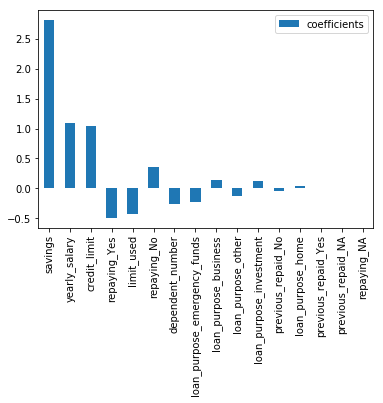

In [11]:
model.print_summary()

### Random Forest Example

##### Define parameters

In [12]:
# same as above except one-hot encoding is not needed this time
one_hot = False

##### Create a Data object

In [13]:
data = Data(loan_file, borrower_file, target_col, id_col, granted_col, drop_cols, one_hot)

In [14]:
data.df_train.head()

,loan_id,loan_purpose,loan_repaid,previous_repaid,repaying,credit_limit,limit_used,yearly_salary,dependent_number,savings
0,580653,4,1.0,2,1,5400,0.52,15800,4,6109
1,172419,0,0.0,0,0,2900,0.76,34800,4,4745
2,780070,0,1.0,2,1,7800,0.30,51100,2,8574
3,303138,1,0.0,1,2,4300,1.02,15000,2,2483
4,91475,3,1.0,2,1,3900,0.65,12000,1,5632


In [15]:
data.df_test.head()

,loan_id,loan_purpose,loan_repaid,previous_repaid,repaying,credit_limit,limit_used,yearly_salary,dependent_number,savings
0,19454,3,NaN,0,0,8600,0.79,45200,7,7776
1,496811,3,NaN,0,0,5300,0.52,0,5,5934
2,929493,4,NaN,0,0,0,0.00,26500,4,3892
3,77085,4,NaN,0,0,3000,0.82,0,3,4297
4,422392,0,NaN,2,2,1000,1.09,0,2,1542


In [16]:
data.feature_cols

['loan_purpose',
 'previous_repaid',
 'repaying',
 'credit_limit',
 'limit_used',
 'yearly_salary',
 'dependent_number',
 'savings']

##### Create a Model object, train the Random Forest and make predictions

In [17]:
model = Model()
model.train(data, model="RF", scoring='roc_auc', k=3, tune=False)

In [18]:
model.predict()

array([0.99908136, 0.94474787, 0.09549128, ..., 0.01531307, 0.01192037,
       0.13131276])

--- Model Summaries ---

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Cross-validation Score: 0.965668335852838

Feature Importances:

                  importances
savings              0.559866
yearly_salary        0.161415
credit_limit         0.133414
repaying             0.066722
limit_used           0.039876
dependent_number     0.017784
loan_purpose         0.013507
previous_repaid      0.007415


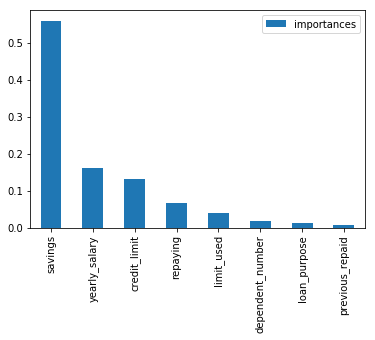

In [19]:
model.print_summary()